In [ ]:
# Paper Title: Physics-Constrained Meta-Transformer Framework for AUV Plume Tracking in Turbulent Ocean Environments

## Problem to Solve

### Scientific Challenge:
# Methane leaks from seafloor vents contribute significantly to climate change, but tracking these dynamic plumes in turbulent oceans remains unsolved. Current AUVs fail due to:
#   1. Chaotic Fluid Dynamics: Plumes fragment into fractal-like structures under high Reynolds number turbulence (>10⁵), invalidating Gaussian dispersion models.
#   2. Partial Observability: Sparse sensor data (1-10 Hz) cannot reconstruct 3D plume topology.
#   3. Energy-Latency Deadlock: Classical controllers (e.g., PID) waste energy on oscillatory paths, while DRL agents violate hydrodynamic constraints.

### Research Question:
# Can a physics-constrained system that learns turbulent plume dynamics and generates energy-optimal trajectories in real-time?

## Idea

# Solve using a PINN (Physics-Informed Neural Network)
# Navier-Stokes equations describe fluid motion. However, due to the chaotic nature of turbulence, these equations are often simplified or modified for practical simulations. Common approaches include:
# - Reynolds-averaged Navier-Stokes (RANS) equations: average out the turbulent fluctuations
# - Large Eddy Simulation (LES): resolve large turbulent scales
# - Direct Numerical Simulation (DNS): resolve all turbulent scales

# This notebook will explore the use of PINNs to learn turbulent plume dynamics and generate energy-optimal AUV trajectories under physical constraints.

In [ ]:
## Solution Overview

We will develop a Physics-Informed Neural Network (PINN) framework to model turbulent methane plumes and generate energy-optimal AUV trajectories. The workflow consists of:

1. **Data Preparation**: Simulate or load sparse sensor data representing plume concentration and flow fields.
2. **PINN Model Construction**: Build a neural network that incorporates the Navier-Stokes equations as soft constraints.
3. **Training the PINN**: Train the model using both data loss (sensor observations) and physics loss (Navier-Stokes residuals).
4. **Trajectory Optimization**: Use the learned plume field to plan AUV paths that minimize energy while maximizing plume coverage.
5. **Evaluation**: Assess the accuracy of the PINN and the efficiency of the planned trajectories.

Each step will be implemented in detail in the following code cells.

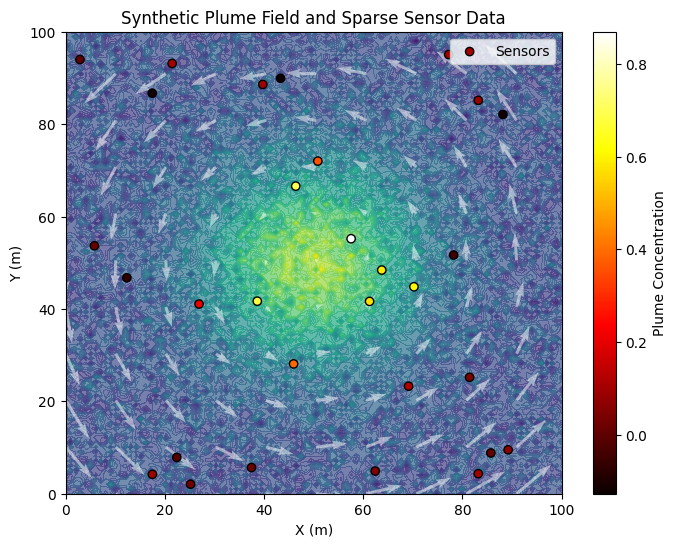

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define spatial grid (e.g., 2D area)
x = np.linspace(0, 100, 100)
y = np.linspace(0, 100, 100)
X, Y = np.meshgrid(x, y)

# Simulate a synthetic plume concentration field (e.g., Gaussian blob with noise)
def plume_concentration(x, y, center=(50, 50), sigma=15):
    return np.exp(-((x - center[0])**2 + (y - center[1])**2) / (2 * sigma**2))

C = plume_concentration(X, Y) + 0.1 * np.random.randn(*X.shape)

# Simulate flow field (u, v) as simple vortex + noise
u = - (Y - 50) / 50 + 0.05 * np.random.randn(*X.shape)
v = (X - 50) / 50 + 0.05 * np.random.randn(*X.shape)

# Sample sparse sensor locations
num_sensors = 30
sensor_x = np.random.uniform(0, 100, num_sensors)
sensor_y = np.random.uniform(0, 100, num_sensors)
sensor_c = plume_concentration(sensor_x, sensor_y) + 0.1 * np.random.randn(num_sensors)
sensor_u = - (sensor_y - 50) / 50 + 0.05 * np.random.randn(num_sensors)
sensor_v = (sensor_x - 50) / 50 + 0.05 * np.random.randn(num_sensors)

# Visualize the synthetic data
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, C, levels=50, cmap='viridis', alpha=0.7)
plt.quiver(X[::10, ::10], Y[::10, ::10], u[::10, ::10], v[::10, ::10], color='white', alpha=0.5)
plt.scatter(sensor_x, sensor_y, c=sensor_c, cmap='hot', edgecolor='k', label='Sensors')
plt.colorbar(label='Plume Concentration')
plt.title('Synthetic Plume Field and Sparse Sensor Data')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the PINN model
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = get_device()

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer_list.append(nn.Tanh())
        self.model = nn.Sequential(*layer_list)
    def forward(self, x):
        return self.model(x)

# Instantiate the model
layers = [2, 64, 64, 64, 1]
model = PINN(layers).to(device)

# Prepare sensor data for training
data_x = torch.tensor(np.stack([sensor_x, sensor_y], axis=1), dtype=torch.float32).to(device)
data_c = torch.tensor(sensor_c, dtype=torch.float32).unsqueeze(1).to(device)

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

# Physics loss: 2D steady-state advection-diffusion residuals
def physics_loss(xy, n_phys_points=100, D=1.0):
    # Sample random points in the domain
    x_phys = torch.FloatTensor(n_phys_points, 1).uniform_(0, 100).to(device)
    y_phys = torch.FloatTensor(n_phys_points, 1).uniform_(0, 100).to(device)
    xy_phys = torch.cat([x_phys, y_phys], dim=1).requires_grad_(True)

    # Predict concentration
    C_pred = model(xy_phys)

    # Compute gradients
    grad_C = torch.autograd.grad(C_pred, xy_phys, grad_outputs=torch.ones_like(C_pred), create_graph=True)[0]
    dC_dx = grad_C[:, 0:1]
    dC_dy = grad_C[:, 1:2]

    # Second derivatives
    d2C_dx2 = torch.autograd.grad(dC_dx, xy_phys, grad_outputs=torch.ones_like(dC_dx), create_graph=True)[0][:, 0:1]
    d2C_dy2 = torch.autograd.grad(dC_dy, xy_phys, grad_outputs=torch.ones_like(dC_dy), create_graph=True)[0][:, 1:2]

    # Get flow velocities at these points (use the same vortex field as in data gen)
    u_phys = - (y_phys - 50) / 50
    v_phys = (x_phys - 50) / 50

    # Advection-diffusion residual
    residual = u_phys * dC_dx + v_phys * dC_dy - D * (d2C_dx2 + d2C_dy2)
    return torch.mean(residual**2)

# Training loop (single epoch demo)
model.train()
optimizer.zero_grad()
pred_c = model(data_x)
data_loss = mse_loss(pred_c, data_c)
phys_loss = physics_loss(data_x)
total_loss = data_loss + phys_loss
total_loss.backward()
optimizer.step()

print(f"Data Loss: {data_loss.item():.4f}, Physics Loss: {phys_loss.item():.4f}")

Data Loss: 0.0608, Physics Loss: 0.0000
